待機児童は仕組み上、２号３号に認定された上での入所申し込みをした数字になっている。より一般的に、児童を受け入れる施設の定員と実際の地域の児童数の関係について分析を試みる。

In [1]:
%matplotlib inline

In [2]:
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.spatial
import functools
import unicodedata
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon

In [3]:
import unittest
T = unittest.TestCase()

In [4]:
fib = gpd.read_file("../data/hkwi/shinseido-2016-09.json").assign(cap=0, name="-")

# nib のセルのいくつかは数値に補足情報が付いているので、除去する
def drop_notes(c):
    if not c:
        return 0
    m = re.match(r'^(\d+)\s*[（\()]内地域枠\d+[）\)]$', c)
    if m:
        return int(m.group(1))
    elif c[-1] in "*＊":
        return int(c[:-1])
    else:
        return int(c)

for i,v in fib.iterrows():
    k = '公立幼稚園,募集クラス数 ３歳'
    if v[k]:
        fib.loc[i, "name"] = v["公立幼稚園,施設名"]
        fib.loc[i,"cap"] += int(unicodedata.normalize("NFKD", v[k])) * 20 # 1 クラス 20 人と仮定
    
    k = '公立幼稚園,募集クラス数 ４歳'
    if v[k]:
        fib.loc[i, "name"] = v["公立幼稚園,施設名"]
        if "無し" in v[k] or v[k] == "混合":
            fib.loc[i,"cap"] += 20
        else:
            fib.loc[i,"cap"] += int(unicodedata.normalize("NFKD", v[k])) * 40 # 5歳は4歳からエレベーターすると仮定
    
    k1 = '１号,認可定員(全体)'
    k2 = "２号３号,利用定員（2・3号）"
    if v[k1]:
        fib.loc[i,"name"] = v["１号,施設名"]
        fib.loc[i,"cap"] += int(unicodedata.normalize("NFKD", v[k1]))
    elif v[k2]:
        fib.loc[i,"name"] = v["２号３号,施設名"]
        fib.loc[i,"cap"] += drop_notes(v[k2])


同一住所に複数の施設が存在したりするので、まず位置情報だけで分割できるようにする。

In [5]:
coords_fib = [r.coords[0] for _,r in fib.geometry.iteritems()]
coords = []
for c in coords_fib:
    if c not in coords:
        coords.append(c)

aib = gpd.GeoDataFrame([{"geometry":Point(x,y)} for x,y in coords], crs="+init=epsg:4326")
fib = pd.concat([fib, pd.Series([coords.index(c) for c in coords_fib], index=fib.index, name="aib")], axis=1)

e-Stat の区域データを読み込む。

In [6]:
us = [gpd.read_file(f) for f in glob.glob("../data/estat/h22ka281*.shp")]
pib_ = gpd.GeoDataFrame(pd.concat(us, ignore_index=True), crs=us[0].crs)
pib = pib_[(pib_["MOJI"]!="水面") & (pib_["MOJI"].isnull()==False)] # 海上を取り除く

be = [("minx",min), ("miny",min), ("maxx",max), ("maxy",max)]
pib_ext = [Point([be[j][1](pib.bounds[be[j][0]]) for j in i])
   for i in ((0,1),(2,1),(2,3),(0,3))]

神戸市の人口データを読み込む。

In [7]:
ages=["%d歳" % i for i in range(6)]+["児童"]
def load_zensi(fname):
    e = pd.ExcelFile(fname)
    opts = dict(skiprows=1, converters={"区コード":str, "町コード":str})
    dfs = [e.parse(s, **opts).iloc[1:,:] for s in e.sheet_names if s != "神戸市"]
    return pd.DataFrame(pd.concat(dfs, ignore_index=True))

zib = load_zensi("../data/kobe/zensi2808.xls").assign(
    ages_total=lambda r:r[ages[:-1]].sum(axis=1),
).rename(columns={"ages_total":"児童"})

keycodes = set(pib["KEYCODE1"])

try:
    cache = pd.read_json(open("../cache/kobe.json", encoding="UTF-8")).T
except:
    cache = pd.DataFrame([], columns=["lat", "lng"])

# KEYCODE1 が存在しないものについて、Point を求める
zib_ = zib[zib["町コード"].isin(keycodes)==False].apply(
    lambda r:"神戸市 %s %s" % (r["区・支所"].replace("支所",""), r["町名"]),
    axis=1
).rename("qname").to_frame().join(
    cache,
    on="qname"
)[["lat","lng"]].dropna().apply(
    lambda r:Point(r["lng"], r["lat"]),
    axis=1
).rename("geometry")

# KEYCODE1 を揃えて求める
zib_ = pd.concat([
    zib,
    gpd.tools.sjoin(gpd.GeoDataFrame(zib_, crs="+init=epsg:4326").to_crs(pib.crs), pib, op="within")["KEYCODE1"]
], axis=1).apply(
    lambda r:r["町コード"] if r["町コード"] in keycodes else r["KEYCODE1"],
    axis=1
).rename("KEYCODE1")

# 人口データに KEYCODE1 を追加する
zib = pd.concat([zib, zib_], axis=1)

ボロノイ図関連のルーチンを用意する。

In [8]:
def voronoi(npts):
    # Add extra points to create closed Polygon for all facilities
    ext = []
    for pt in pib_ext:
        dist = npts.distance(pt)
        n = npts[dist==min(dist)].geometry.iloc[0]
        ext.append(Point(pt.x*2 - n.x, pt.y*2 - n.y))

    npts_ext = gpd.GeoDataFrame([dict(geometry=p, dummy=1) for p in ext])
    g = gpd.GeoDataFrame(pd.concat([npts, npts_ext], ignore_index=True))
    v = scipy.spatial.Voronoi([p.coords[0] for i,p in g.geometry.iteritems()])
    return v

def voronoi2region(npts, v, **kwargs):
    vp = [dict(geometry=Polygon([v.vertices[vt] for vt in v.regions[r]]),
            aib=npts.index[i], **kwargs)
        for i,r in enumerate(v.point_region) if -1 not in v.regions[r]]
    assert len(vp) == npts.shape[0]
    return vp

児童数を e-Stat の区域に振り分けます。

In [9]:
pib_pop = pib.join(
    zib.groupby("KEYCODE1").sum()[ages],
    on="KEYCODE1"
).join(
    pd.concat([pib["KEYCODE1"], pib.geometry.area], axis=1).groupby("KEYCODE1").sum().rename(columns={0:"area_sum"}),
    on="KEYCODE1"
)
pib_pop_ = pib_pop[ages].mul(pib_pop.geometry.area / pib_pop["area_sum"], axis=0)
pib_pop = pib_pop.assign(
     **{k:pib_pop_[k] for k in ages}
)

この計算では人口データを e-Stat の区域に割り振りました。割り振りが正しかったかを念のため合計で検算します。

In [10]:
for k in ages:
    T.assertAlmostEqual( pib_pop[k].sum(), zib[k].sum() )

人口データを近隣領域に拡散させて、可視化しやすくします。

In [11]:
xpib_ = gpd.GeoDataFrame(pd.concat([pib["geometry"],
    pd.Series(pib.index, index=pib.index, name="pib")], axis=1)).assign(one=1)
xpib = gpd.tools.sjoin(xpib_, xpib_, op="intersects")

pib_pop2_ = xpib.join(
    xpib.groupby("pib_left").sum()["one_left"].rename("counts"),
    on = "pib_left"
).join(
    pib_pop[ages],
    on = "pib_left"
)
pib_pop2 = pib_pop2_.assign(
    **{k:pib_pop2_[k]/pib_pop2_["counts"] for k in ages}
).groupby("pib_right").sum()
# 検算
for k in ages:
    T.assertAlmostEqual( pib_pop2[k].sum(), zib[k].sum() )

プロットして拡散できたか確認します。

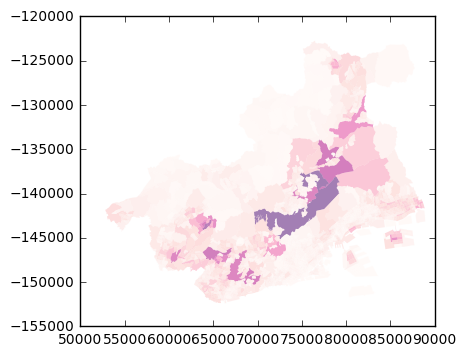

In [12]:
g = gpd.GeoDataFrame(pd.concat([pib["geometry"], pib_pop2[ages].sum(axis=1).rename("sum")], axis=1))
_ = g.plot(column="sum", cmap="RdPu", linewidth=0)

## 定員

児童の数と地域の施設の定員の関係を求める。

In [13]:
# CRS は面積の計算できる座標系に揃える。
v = voronoi(aib.to_crs(pib.crs))
r = gpd.GeoDataFrame(voronoi2region(aib, v), crs=pib.crs)

In [14]:
aib_neigh = pd.DataFrame(np.r_[
    v.ridge_points,
    v.ridge_points.dot(np.array([[0,1],[1,0]])),
    np.array([[i, i] for i in range(len(aib.index))])
], columns=["L","R"]).applymap(
    lambda x:aib.index[x] if x<len(aib.index) else None
).dropna()

施設で形成されるボロノイ区域と、人口統計の区域の積を取る。

In [15]:
pib_ = gpd.GeoDataFrame(pd.concat([pib, pd.Series(pib.index, index=pib.index, name="pib")], axis=1)) # pib index 行を付与する
ta = gpd.overlay(pib_, r, how="union") # この計算は重い！

神戸市の区域外の範囲を落としておく。

In [16]:
tv = ta[ta["pib"].isnull()==False]
tv.crs = pib.crs

細分化されたエリアに人口を再配分してから、施設ごとに合算する。

In [17]:
# pib.geometry.area を直接使うと、値がくるう
# 人数の合計値だけは合致するようにする。
tv_pop = tv.join(
    pd.concat([(tv.geometry.area).rename("pib_area"), tv], axis=1).groupby("pib").sum()["pib_area"],
    on="pib"
).join(
    pib_pop2[ages],
    on="pib"
)
tv_pop = tv_pop.assign(
    **{k: tv_pop[k].mul( tv_pop.geometry.area / tv_pop["pib_area"] , axis=0) for k in ages}
)
aib_pop = tv_pop.groupby("aib").sum()[ages]

児童数の合計値が正しいか検算する。

In [18]:
for k in ages:
    T.assertAlmostEqual( aib_pop.sum()[k], zib[ages].sum()[k] )

# T.assertAlmostEqual( tv.geometry.area.sum(), pib.geometry.area.sum() )

In [19]:
# geopands.overlayバグの検査用
for i in pib.index:
    a = pib.loc[i].geometry.area
    b = tv[tv["pib"]==i].geometry.area.sum()
    try:
        T.assertAlmostEqual( a, b )
    except:
        print(i, a, b)

ボロノイ図の領域を隣接する一回り大きい領域にして、各領域にいる人口に応じて定員を再配分する。

In [20]:
aib_cap = aib_neigh.join(
    aib_neigh.join(aib_pop, on="L").groupby("R").sum()[ages].rename(columns={k:"sum_"+k for k in ages}),
    on="L"
).join(
    aib_pop,
    on="R"
).join(
    fib.groupby("aib").sum()["cap"],
    on="L"
).assign(
    cap = lambda p:p["cap"].mul( p["児童"] / p["sum_児童"], axis=0)
).groupby("R").sum()["cap"]

申込児童数の合計値で検算する。

In [21]:
T.assertAlmostEqual( aib_cap.sum(), fib["cap"].sum() )

施設ごとに区域を合併させる。

In [22]:
aib_g_ = [functools.reduce(lambda x,y: x.union(y), tv[tv["aib"]==pti].geometry) for pti in aib.index]
aib_g = pd.Series(aib_g_, index=aib.index, name="geometry")

## 結果

地図上にプロットするとこのようになった。赤が激戦区となる。

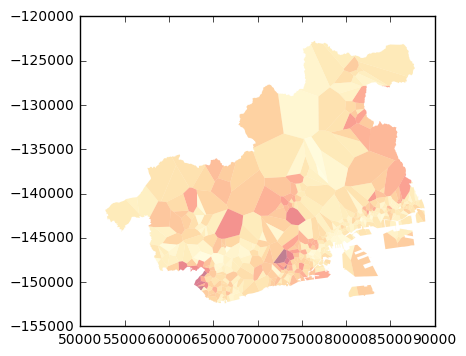

In [23]:
g = gpd.GeoDataFrame(pd.concat([aib_g, (aib_cap/aib_pop["児童"]).rename("rate")], axis=1))
_ = g.plot(column="rate", cmap="YlOrRd", linewidth=0)

## 定員の変換の確認

In [24]:
pltopts = dict(column="rate", cmap="autumn_r", linewidth=0, alpha=1)

定員ストレート値。ボロノイ図での割り当て面積で割った、単位面積当たりの定員。

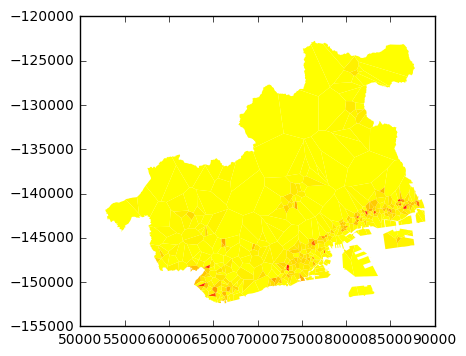

In [25]:
g1 =gpd.GeoDataFrame(pd.concat([aib_g, fib.groupby("aib").sum()["cap"]], axis=1))
_ = g1.assign(rate=lambda d:d["cap"]/d.geometry.area).plot(**pltopts)

申込数周辺拡散値。ボロノイ図での割り当てで、隣接周辺区域も含めた面積で割った、単位面積当たりの定員。

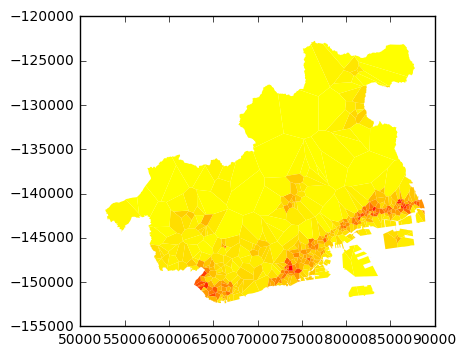

In [26]:
g2 = gpd.GeoDataFrame(pd.concat([aib_g, aib_cap], axis=1))
_ = g2.assign(rate=lambda d:d["cap"]/d.geometry.area).plot(**pltopts)

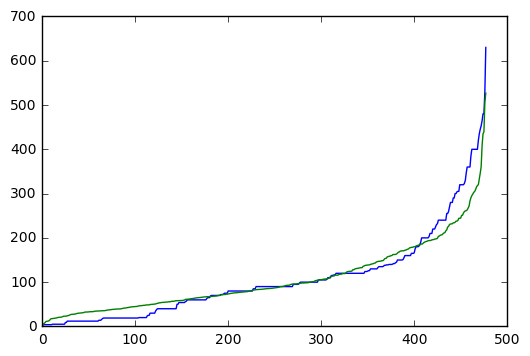

In [27]:
_ = plt.plot(sorted(fib.groupby("aib").sum()["cap"]))
_ = plt.plot(sorted(aib_cap))

## 児童数の変換の確認

In [28]:
pltopts = dict(column="rate", cmap="Set3", alpha=1, linewidth=0)

ストレート値。児童数の人口密度でプロット。

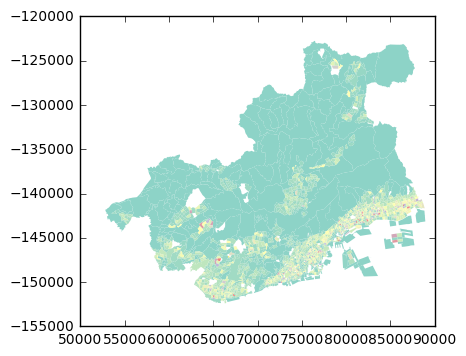

In [29]:
g = pib_pop[pib_pop["児童"].isnull()==False]
_ = g.assign(rate=lambda d:d["児童"]/d.geometry.area).plot(**pltopts)

児童数を隣接区域で拡散させた値。

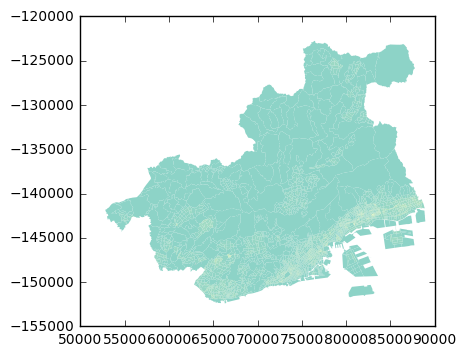

In [30]:
g=gpd.GeoDataFrame(pd.concat([pib["geometry"], pib_pop2["児童"]], axis=1))
_ = g.assign(rate=lambda d:d["児童"]/d.geometry.area).plot(**pltopts)

ボロノイ分割で値を再配分

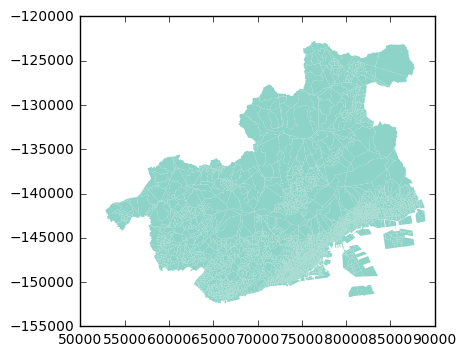

In [31]:
_ = tv_pop.assign(rate=lambda d:d["児童"]/d.geometry.area).plot(**pltopts)

ボロノイ区画で値を集約

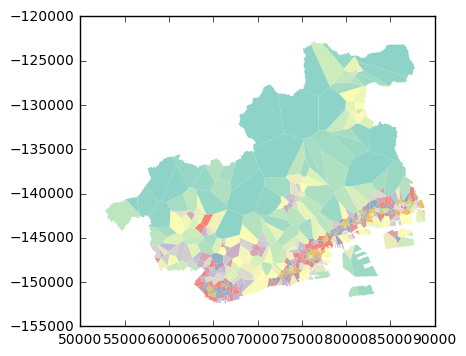

In [32]:
g = gpd.GeoDataFrame(pd.concat([aib_g, aib_pop], axis=1))
_ = g.assign(rate=lambda d:d["児童"]/d.geometry.area).plot(**pltopts)